In [199]:
import pandas as pd 
import os

from sklearn.model_selection import train_test_split

import cv2
from PIL import Image

from tqdm import tqdm

### Read data in & create train/test splits

In [202]:
# get pathways 

dir_path = "../data/classification_images/"
success_uids = os.listdir(dir_path)

strat_train = pd.read_csv('../data/training_data.csv').reset_index()
strat_train['im'] = None
strat_train['label'] = strat_train['classification'].map({'no-damage': 0, 'minor-damage': 1, 'major-damage': 2, 'destroyed': 3, 'un-classfied': 4})

strat_test = pd.read_csv('../data/validation_data.csv').reset_index()
strat_test['im'] = None
strat_test['label'] = strat_test['classification'].map({'no-damage': 0, 'minor-damage': 1, 'major-damage': 2, 'destroyed': 3, 'un-classfied': 4})


In [203]:
# These are the class labels we expect the CNN to be able to recognize
strat_train['classification'].value_counts()

no-damage        117346
minor-damage      14976
major-damage      14159
destroyed         13225
un-classified      2992
Name: classification, dtype: int64

### Processing Data to correct shapes

In [204]:
import torch
import tensorflow.keras as keras
import numpy as np

# Checking if CUDA is available
flag_cuda = torch.cuda.is_available()

if not flag_cuda:
    print('Using CPU')
else:
    print('Using GPU')

Using CPU


Prepare image through changing dimensionality 

In [205]:
def prepare(dataframe, path, dimensions): 
    for l in tqdm(range(0, len(dataframe))): 
        path_image = '../data/' + path + '/images/' + dataframe['image_name'][l].split(".json")[0] + ".png"
        img = cv2.imread(path_image)

        resize = cv2.resize(img, dimensions, interpolation = cv2.INTER_AREA)
        # resize = [item for sublist in resize for item in sublist]
        img = resize / 255
        dataframe['im'][l] = img

    return dataframe

In [206]:
strat_train = prepare(strat_train, 'train', (35, 35))

  0%|          | 0/162698 [00:00<?, ?it/s]/var/folders/sx/gfq_y8592_bdyxcm2vgcj7dc0000gp/T/ipykernel_73178/3291486104.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 162698/162698 [1:54:29<00:00, 23.68it/s]   


In [207]:
print(strat_train['im'][0].shape)
type(strat_train['im'][0])


(35, 35, 3)


numpy.ndarray

In [209]:
x_train = strat_train['im']
x_train = np.concatenate(x_train).reshape(len(strat_train), 35, 35, 3)
print("This is the training data shape: ")
x_train.shape

This is the training data shape: 


(162698, 35, 35, 3)

In [210]:
strat_test = prepare(strat_test, 'hold', (35, 35))
x_test = strat_test['im']
x_test = np.concatenate(x_test).reshape(len(strat_test), 35, 35, 3)
print("This is the validation data shape: ")
x_test.shape

  0%|          | 0/54307 [00:00<?, ?it/s]/var/folders/sx/gfq_y8592_bdyxcm2vgcj7dc0000gp/T/ipykernel_73178/3291486104.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 54307/54307 [23:07<00:00, 39.14it/s]


This is the validation data shape: 


(54307, 35, 35, 3)

In [ ]:
strat_test_final = prepare(strat_test_final, 'test', (35, 35))
x_test = strat_test_final['im']
x_test = np.concatenate(x_test).reshape(len(strat_test_final), 35, 35, 3)
print("This is the testing data shape: ")
x_test.shape

In [211]:
# Turn our scalar targets into binary categories
num_classes = 5
y_train = keras.utils.to_categorical(strat_train['label'], num_classes)
y_test = keras.utils.to_categorical(strat_test['label'], num_classes)
# y_test_final = keras.utils.to_categorical(strat_test_final['label'], num_classes)

/Users/nakraft/Documents/school/CSC 591 - Neural Networks/my_venv/lib/python3.8/site-packages/pandas/core/series.py:893: RuntimeWarning:

invalid value encountered in cast



## Creating the CNN

In [216]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(35, 35, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

In [217]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 35, 35, 75)        2100      
                                                                 
 batch_normalization_9 (Batc  (None, 35, 35, 75)       300       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 18, 18, 75)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 18, 18, 50)        33800     
                                                                 
 dropout_6 (Dropout)         (None, 18, 18, 50)        0         
                                                                 
 batch_normalization_10 (Bat  (None, 18, 18, 50)      

In [219]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [220]:
history = model.fit(x_train, y_train, epochs=20, verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
5085/5085 [==============================] - 135s 27ms/step - loss: 0.4834 - accuracy: 0.8301 - val_loss: 0.8582 - val_accuracy: 0.7189
Epoch 2/20
5085/5085 [==============================] - 127s 25ms/step - loss: 0.3960 - accuracy: 0.8547 - val_loss: 0.9491 - val_accuracy: 0.6781
Epoch 3/20
5085/5085 [==============================] - 126s 25ms/step - loss: 0.3751 - accuracy: 0.8597 - val_loss: 0.9103 - val_accuracy: 0.7189
Epoch 4/20
5085/5085 [==============================] - 128s 25ms/step - loss: 0.3633 - accuracy: 0.8630 - val_loss: 0.8607 - val_accuracy: 0.6835
Epoch 5/20
5085/5085 [==============================] - 144s 28ms/step - loss: 0.3555 - accuracy: 0.8663 - val_loss: 0.8463 - val_accuracy: 0.7181
Epoch 6/20
5085/5085 [==============================] - 134s 26ms/step - loss: 0.3508 - accuracy: 0.8665 - val_loss: 0.8941 - val_accuracy: 0.7247
Epoch 7/20
5085/5085 [==============================] - 131s 26ms/step - loss: 0.3479 - accuracy: 0.8672 - val_loss: 0

In [225]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter( y=history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['loss'], name="loss"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( y=history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter( y=history.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Loss/Accuracy of Sequential CNN Model"
)

# Set x-axis title
fig.update_xaxes(title_text="Epoch")

# Set y-axes titles
fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.show()



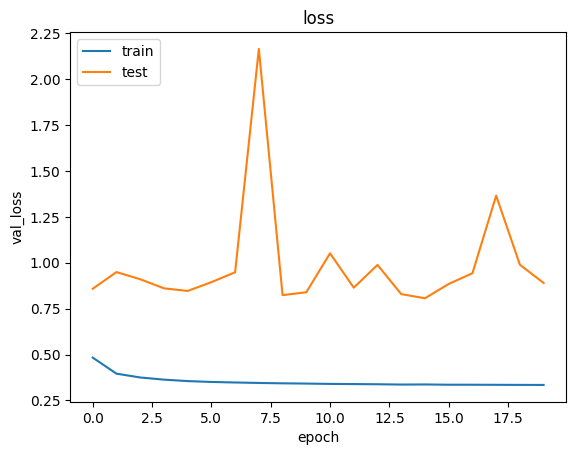

In [224]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

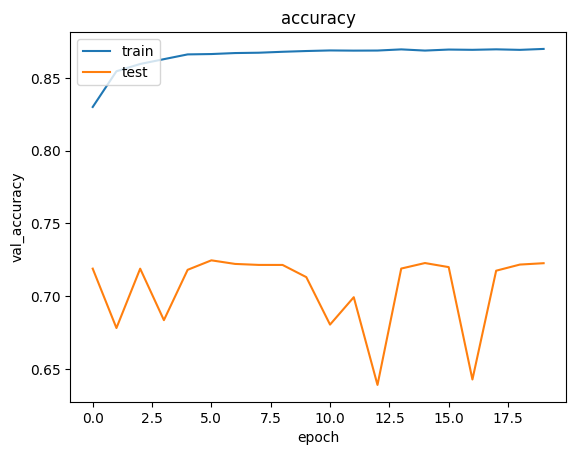

In [226]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [229]:
strat_train.to_csv("../data/strat_train.csv", index=False)
strat_test.to_csv("../data/strat_test.csv", index=False)

In [235]:
strat_train.shape

(162698, 7)